# predicting the health uninsured in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import numpy as np
from dotenv import load_dotenv
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# call api for more details on a specific variable
load_dotenv()
API_KEY  = os.getenv('CENSUS_API_KEY')
def variableDetails(codename):
    host     = 'https://api.census.gov/data'
    year     = 2019
    dataset  = 'acs/acs1/pums/variables'
    query    = '?get='
    base_url = "/".join([host, str(year), dataset, codename + '.json']) 
    r        = requests.get(base_url)
    detail   = r.json()
    return detail

Load the cleaned data from csv file. 

In [3]:
nsamples = 500
datadir  = os.path.join(os.getcwd(),"data")
fname    = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '.csv')
df       = pd.read_csv(fname)

In [4]:
print(df.shape)
print(df.info())
df.drop('Unnamed: 0',axis=1,inplace=True)
print(df.dtypes[df.dtypes == 'object'])

(25500, 458)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25500 entries, 0 to 25499
Columns: 458 entries, Unnamed: 0 to STATE
dtypes: float64(2), int64(455), object(1)
memory usage: 89.1+ MB
None
STATE    object
dtype: object


We know that there are a number of categorical variables in the dataset, as well as numerical variables. We can use the predictive power score (pps) to estimate the predictive power of each variable for our target variable. However, to use the predictive power score, we need to convert categorical variables to data type 'category.' 

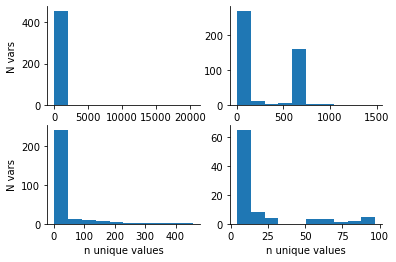

In [5]:
#try to identify categorical variables by considering number of unique values?
plt.figure()
plt.subplot(2,2,1)
plt.hist(df.nunique()) 
plt.ylabel('N vars')
plt.title('')
sns.despine()

plt.subplot(2,2,2)
plt.hist(df.nunique()[df.nunique().between(1,1500)])
sns.despine()

plt.subplot(2,2,3)
plt.hist(df.nunique()[df.nunique().between(1,500)])
sns.despine()
plt.xlabel('n unique values')
plt.ylabel('N vars')

plt.subplot(2,2,4)
plt.hist(df.nunique()[df.nunique().between(4,100)])
sns.despine()
plt.xlabel('n unique values')
plt.show()

In [6]:
# spot check info available for a variable that is very likely categorical (<=3 unique values)
cols = df.columns[df.nunique().between(2,3)]
dets = variableDetails(cols[0])
print(dets['label'])
print(dets['values'])

Bathtub or shower allocation flag
{'item': {'1': 'Yes', '0': 'No', '-1': 'N/A (GQ)'}}


In [7]:
# spot check info available for a variable that is very likely numerical (> 500 unique values)
cols = df.columns[df.nunique().gt(800)]
dets = variableDetails(cols[1])
print(dets['label'])
print(dets['values'])

Total person's income (signed, use ADJINC to adjust to constant dollars)
{'item': {'-19999': 'N/A (less than 15 years old)', '-19998': 'Loss of $19998 or more (Rounded and bottom-coded components)', '0': 'None'}, 'range': [{'min': '-19997', 'max': '-1', 'description': 'Loss $1 to $19997 (Rounded components)'}, {'min': '1', 'max': '4209995', 'description': '$1 to $4209995 (Rounded and top-coded components)'}]}


We know that the index column comes from the index in the row from our api call. It is categorical and at this point we do not need it, so we can drop. 

In [8]:
df.drop('index',axis=1,inplace=True)

It looks like info on numerical values (like in the immediate cell above) includes a 'range' key to indicate the min and max of that numerical variable, while categorical variables do not include that information. Maybe we can use this to identify categorical/numerical variables. 

In [9]:
# is 'range' key (numerical) in information for each variable from the api?
# call API for states in loop and save csv locally if it doesn't exist yet:
fname = os.path.join(datadir,'datatype_ncol' + str(df.shape[1]) + '.csv')
if os.path.exists(fname) == False:  
    flag_columns = ['STATE']
    range_key = list()
    info_from_api = list()
    var_name = list()
    n_unq_vals = list()
    for column in df:
        try: 
            var_name.append(column)
            if column in flag_columns:
                range_key.append(False)
                info_from_api.append(False)
                n_unq_vals.append(df[column].nunique())
            else:
                dets = variableDetails(column)
                range_key.append('range' in dets['values'].keys())
                info_from_api.append(True)
                n_unq_vals.append(df[column].nunique())
        except:
            var_name.append(column)
            range_key.append(False)
            info_from_api.append(False)
            n_unq_vals.append(df[column].nunique())
            print('check this variable again: ' + column)
    datatype = pd.DataFrame({'var_name':var_name,'range_key':range_key,'n_unq_vals':n_unq_vals,'info_from_api':info_from_api})
    datatype.to_csv(fname)
else:
    datatype = pd.read_csv(fname)

In [10]:
print('The number of columns in our main df should equal the number of rows in our datatype dataframe: ')
print('df column N:' + str(datatype.shape[1]))
print('datatype rows N:' + str(datatype.shape[0]))
print('The only vars where numerical info is not from the api:')
print(datatype[datatype.info_from_api == False]['var_name'])

The number of columns in our main df should equal the number of rows in our datatype dataframe: 
df column N:5
datatype rows N:456
The only vars where numerical info is not from the api:
455    STATE
Name: var_name, dtype: object


We can do another check to see if this approach is adding up. Are there any variables coming out as categorical that have a very high number of unique values? Are any coming out as numerical that have very few unique values? 

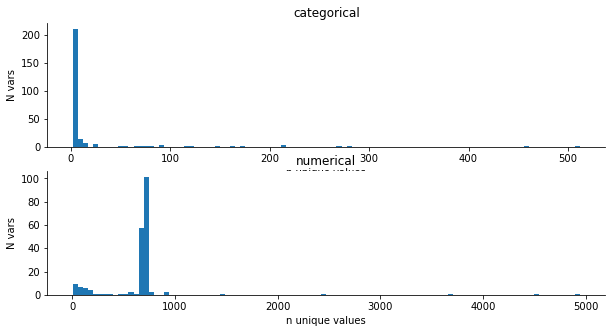

In [11]:
# now we can look at the distributions of N unique values for our columns again with our categorical/numerical labels
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
#plt.hist(df.iloc[:,datatype['range_key'].loc[datatype['range_key']==False].index].nunique(),bins=100) 
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==False],bins=100) 

plt.ylabel('N vars')
plt.xlabel('n unique values')
plt.title('categorical')
sns.despine()

plt.subplot(2,1,2)
#plt.hist(df.iloc[:,datatype['range_key'].loc[datatype['range_key']==True].index].nunique(),bins=100)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==True],bins=100) 
plt.xlabel('n unique values')
plt.ylabel('N vars')

plt.title('numerical')
sns.despine()

plt.show()

In [12]:
# we can check our vars that lie on the unexpected extremes (low unique N, numerical):
print('var with min number of unique values that may be numerical:') 
min_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==True].idxmin()]

# get deets:
dets = variableDetails(min_cat_row['var_name'])
print(dets)

var with min number of unique values that may be numerical:
{'name': 'RACNUM', 'label': 'Number of major race groups represented', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP', 'values': {'range': [{'min': '1', 'max': '6', 'description': 'Race groups'}]}}


This is numerical, so the approach may be working..

In [13]:
# we can check our vars that lie on the unexpected extremes (high unique N, categorical)::
print('var with max number of unique values that may be categorical:') 
max_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==False].idxmax()]

print(max_cat_row)

# get deets:
dets = variableDetails(max_cat_row['var_name'])
print(dets)

var with max number of unique values that may be categorical:
Unnamed: 0         218
var_name          OCCP
range_key        False
n_unq_vals         512
info_from_api     True
Name: 218, dtype: object
{'name': 'OCCP', 'label': 'Occupation recode for 2018 and later based on 2018 OCC codes', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP', 'values': {'item': {'4020': 'EAT-Cooks', '4130': 'EAT-Dining Room And Cafeteria Attendants And Bartender Helpers', '5150': 'OFF-Procurement Clerks', '5340': 'OFF-New Accounts Clerks', '5730': 'OFF-Medical Secretaries and Administrative Assistants', '6530': 'CON-Structural Iron And Steel Workers', '7140': 'RPR-Aircraft Mechanics And Service Technicians', '9040': 'TRN-Air Traffic Controllers And Airfield Operations Specialists', '9': 'N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)', '0420': 'MGR-Social And Community Service Managers', '1541': 'ENG-Architectural And Civil Drafters',

This one also checks out. Now we can convert the datatypes in the main df.

In [14]:
datatype.set_index('var_name',inplace=True)

In [15]:
#convert the datatypes
print('converting data types...')
for index in datatype.index:
    if datatype.loc[index].range_key == False:
        df[index] = df[index].astype('category')

converting data types...


In [16]:
df.dtypes

HHLANP     category
FBATHP     category
DRIVESP    category
WGTP23        int64
WGTP22        int64
             ...   
PERNP         int64
SCH        category
TEL        category
TEN        category
STATE      category
Length: 456, dtype: object

Now with our columns converted into appropriate data types, we can compute the predictive power score between each column and our target variable, (health insured or not). 

In [17]:
# try predictive power score to see if there's a relationship between our target var and other columns
target = 'FHICOVP'
predictors_df = pps.predictors(df, y=target,sorted=True,random_seed=123)
predictors_df.set_index('x',inplace=True)
predictors_df.head()

,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
x,,,,,,,,
FPRIVCOVP,FHICOVP,0.972462,classification,True,weighted F1,0.750933,0.993141,DecisionTreeClassifier()
FPUBCOVP,FHICOVP,0.560144,classification,True,weighted F1,0.750933,0.890446,DecisionTreeClassifier()
FHINS7P,FHICOVP,0.476870,classification,True,weighted F1,0.750933,0.869705,DecisionTreeClassifier()
FHINS6P,FHICOVP,0.466229,classification,True,weighted F1,0.750933,0.867055,DecisionTreeClassifier()
FHINS1P,FHICOVP,0.437580,classification,True,weighted F1,0.750933,0.859920,DecisionTreeClassifier()


In [18]:
print(df.shape)
print(predictors_df.shape) # the number of rows in predictors_df is off by one from the main df because it excludes our target variable

(25500, 456)
(455, 8)


In [19]:
def ecdf(x):
    y = list()
    for i in x:
        y.append(sum(x <= i)/len(x))
    return x,y

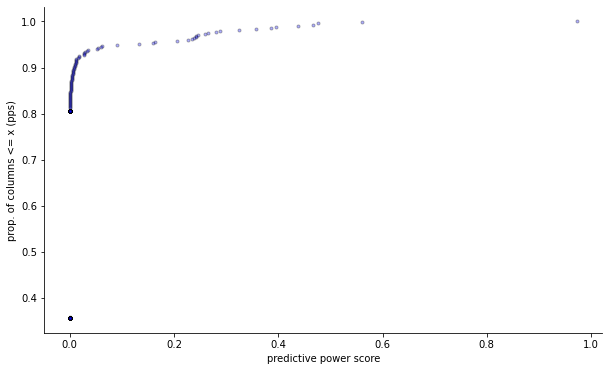

455
455


In [20]:
fig,ax=plt.subplots(figsize=(10,6))

x,y=ecdf(predictors_df['ppscore'])
ax.plot(x,y,marker='.',linestyle='None',color='None',markerfacecolor='blue',alpha=0.3)
sns.despine()
sns.color_palette('hls',8)
ax.set_xlabel('predictive power score')
ax.set_ylabel('prop. of columns <= x (pps)')

plt.show()

print(len(x))
print(len(y))

In [21]:
print('The proportion of points with a predictive power score of 0 is ' + str(y[len(y)-1]) + '.')
print('We can move forward by dropping the bottom ' + str(int(y[len(y)-1]*len(y))) + ' columns right off the bat.')

The proportion of points with a predictive power score of 0 is 0.35604395604395606.
We can move forward by dropping the bottom 162 columns right off the bat.


In [22]:
pps_0 = predictors_df[predictors_df['ppscore'] == 0].index
predictors_df = predictors_df.drop(index=pps_0,axis=0)
datatype = datatype.drop(index=pps_0,axis=0)
print(df.shape)
df = df.drop(pps_0,axis=1)
print(df.shape)
print(predictors_df.shape)

(25500, 456)
(25500, 294)
(293, 8)


It looks like one or two columns have a very high pps--going to check that there are not other medical insurance related columns being used as potential predictors. 

In [23]:
# load variable names from census PUMS (public use microsample) API
load_dotenv()
API_KEY  = os.getenv('CENSUS_API_KEY')
host     = 'https://api.census.gov/data'
year     = 2019
dataset  = 'acs/acs1/pums/variables'
base_url = "/".join([host, str(year), dataset]) 
r        = requests.get(base_url)
rlists   = r.json()
code     = [item[0] for item in rlists if item[0].isupper()] #code in API
label    = [item[1].lower() for item in rlists if item[0].isupper()] # description for each code
nsamples = 500

codedict = {} # redudant with code, label but may make life easier later on
count    = 0
for lab in label:
    codedict[code[count]] = lab
    count += 1
# check for target variable (health insured or not):
insurance_columns = list()
for key, value in codedict.items():
    if value.__contains__('insurance'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('health care'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('health service'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('health coverage'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('medi'):
        print(key + " : " + value)
        insurance_columns.append(key)         

PUBCOV : public health coverage recode
PRIVCOV : private health insurance coverage recode
FINSP : fire, hazard, flood insurance (yearly amount) allocation flag
FMRGIP : first mortgage payment includes fire, hazard, flood insurance allocation flag
HICOV : health insurance coverage recode
FPUBCOVP : public health coverage recode allocation flag
MRGI : first mortgage payment includes fire/hazard/flood insurance
FHICOVP : health insurance coverage recode allocation flag
FPRIVCOVP : private health insurance coverage recode allocation flag
FHINS7P : indian health service allocation flag
FHINS6P : va (enrolled for va health care) allocation flag
INSP : fire/hazard/flood insurance (yearly amount, use adjhsg to adjust insp to constant dollars)
HINS6 : va (enrolled for va health care)
HINS7 : indian health service
HINS1 : insurance through a current or former employer or union
HINS2 : insurance purchased directly from an insurance company
HINS3 : medicare, for people 65 and older, or people with

If a medical insurance column other than our target exists in our main dataframe we should drop it because in theory we shouldn't have this information.

In [24]:
# FHICOVP is our target, so not a predictor
# we already dropped 'HICOV' in data cleaning but we can check the other two vars
for i in insurance_columns:
    if i != target:
        if i in df.columns:
            df.drop(i,axis=1,inplace=True)
            predictors_df.drop(i,axis=0,inplace=True)
            datatype.drop(i,axis=0,inplace=True)

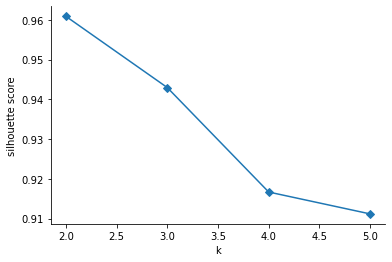

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pps = predictors_df[['ppscore']]
ks = [2,3,4,5]
silh_score = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pps)
    silh_score.append(silhouette_score(pps,kmeans.predict(pps)))
plt.plot(ks,silh_score,marker='D')
plt.xlabel("k")
plt.ylabel('silhouette score')
sns.despine()
plt.show()

In [26]:
k_best = ks[silh_score.index(max(silh_score))]
kmeans = KMeans(n_clusters=k_best)
kmeans.fit(pps)
clust = kmeans.labels_

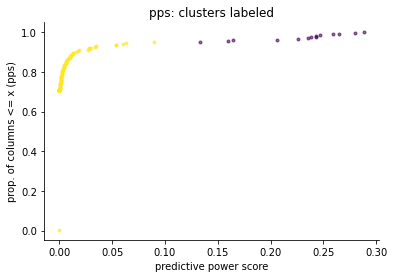

In [27]:
from matplotlib import cm
cmap=cm.get_cmap('viridis_r', k_best)
colors = cmap.colors

fig,ax=plt.subplots()
x,y=ecdf(predictors_df['ppscore'])
for i in range(len(x)):
    ax.plot(x[i],y[i],marker='.',linestyle='None',color=colors[clust[i]],markerfacecolor=colors[clust[i]],alpha=0.6)
sns.despine()
ax.set_xlabel('predictive power score')
ax.set_ylabel('prop. of columns <= x (pps)')
ax.set_title('pps: clusters labeled')
plt.show()

In [28]:
# check which cluster corresponds to higher pps
predictors_df['clust'] = clust
srtdf = predictors_df.groupby('clust').mean().sort_values('ppscore',ascending=True)

In [29]:
worst_clust = srtdf.index[0]

What are the dimensions of the df now? And what are these variables with the highest pp scores, out of curiousity?

In [30]:
pps_0 = predictors_df['ppscore'][clust==worst_clust].index
predictors_df = predictors_df.drop(index=pps_0,axis=1)
datatype = datatype.drop(index=pps_0,axis=1)
print(predictors_df.shape)
print(df.shape)
ndf = df.drop(pps_0,axis=1)
print(ndf.shape)

(14, 9)
(25500, 273)
(25500, 15)


In [31]:
ndf.shape
ndf.rename(columns={'FHICOVP':'not_insured'},inplace=True)
datatype.rename(index={'FHICOVP':'not_insured'},inplace=True)

In [32]:
# save new data frame and predictors_df:
new_df_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_select_columns.csv')
ndf.to_csv(new_df_fname)
pred_df_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_select_columns_predictors_df.csv')
predictors_df.to_csv(pred_df_fname)
datatype_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_select_columns_datatype.csv')
datatype.to_csv(datatype_fname)

In [35]:
print('There are now ' + str(ndf.shape[1]) + ' columns.')

There are now 15 columns.


In [39]:
print(predictors_df.shape)
print(datatype.shape)
print(ndf.shape)

(14, 9)
(15, 4)
(25500, 15)


In [35]:
for i in range(10):
    try:
        dets = variableDetails(predictors_df.index[i])
        print(dets['label'] + ' : ' + str(predictors_df.ppscore[i]))
    except:
        print(predictors_df[i])      

Disability recode allocation flag : 0.2882856804376422
Vision difficulty allocation flag : 0.2802663315677021
Citizenship allocation flag : 0.2651632800831527
School enrollment allocation flag : 0.2589239381597549
Mobility status allocation flag : 0.2469477954174094
Language other than English allocation flag : 0.24312155242070457
Hearing difficulty allocation flag : 0.24304873527494286
Cognitive difficulty allocation flag : 0.23864878072074702
Ambulatory difficulty allocation flag : 0.23562992323019336
Self-care difficulty allocation flag : 0.2263044147657941


Now we can plot the distributions of our variables.

In [36]:
#what kind of variables are left? 
ndf.dtypes.unique()

array([CategoricalDtype(categories=[0, 1], ordered=False)], dtype=object)

Looks like they're all categorical at this point, with 0, 1 values. We can look at the counts of each variable separated by our target variable. 

In [37]:
df1 = pd.DataFrame(columns=df.columns)
df2 = pd.DataFrame(columns=df.columns)

for column in df.columns:
    df1[column] = df.groupby(target)[column].value_counts(normalize=True)  # normalized counts
    df2[column] = df.groupby(target)[column].value_counts(normalize=False) # counts
df1.head(10)

FBATHP   DRIVESP    WGTP25     FWATP    WGTP27    WGTP29  \
FHICOVP                                                                  
0       0   0.940704  0.587175  0.052840  0.893028  0.052793  0.052888   
        -1  0.052793       NaN       NaN  0.052793       NaN       NaN   
        1   0.006503  0.369501  0.000383  0.054179  0.000383  0.000383   
1       0   0.933740  0.667175  0.040541  0.854621  0.040759  0.040541   
        -1  0.040541       NaN       NaN  0.040541       NaN       NaN   
        1   0.025719  0.296861  0.000436  0.104839  0.000218  0.000218   

              WGTP28  FBROADBNDP    FWKWNP    HOTWAT  ...    ACCESS    FPINCP  \
FHICOVP                                               ...                       
0       0   0.052840    0.898671  0.955193  0.052793  ...  0.051836  0.799063   
        -1       NaN    0.052793       NaN       NaN  ...       NaN       NaN   
        1   0.000335    0.048537  0.044807       NaN  ...  0.859889  0.200937   
1       0   0.040541    0.860724  0.836312  0.040541  ...  0.039451  0.619660   
        -1       NaN    0.040541       NaN       NaN  ...       NaN       NaN   
        1   0.001090    0.098736  0.163688       NaN  ...  0.840671  0.380340   

            FOD1P     FMARP    FSMOCP    FDOUTP       SCH       TEL       TEN  \
FHICOVP                                                                         
0       0     NaN  0.971595  0.770801  0.961792  0.027496  0.051836  0.051836   
        -1    NaN       NaN  0.051836       NaN       NaN       NaN       NaN   
        1     NaN  0.028405  0.177362  0.038208  0.744931  0.940417  0.462223   
1       0     NaN  0.849826  0.718396  0.793156  0.030078  0.039669  0.039669   
        -1    NaN       NaN  0.039451       NaN       NaN       NaN       NaN   
        1     NaN  0.150174  0.242153  0.206844  0.762206  0.949869  0.414560   

            STATE  
FHICOVP            
0       0     NaN  
        -1    NaN  
        1     NaN  
1       0     NaN  
        -1    NaN  
        1     NaN  

[6 rows x 273 columns]

In [38]:
codedict

{'HHLANP': 'detailed household language',
 'FBATHP': 'bathtub or shower allocation flag',
 'DRIVESP': 'number of vehicles calculated from jwri',
 'WGTP23': 'housing weight replicate 23',
 'WGTP22': 'housing weight replicate 22',
 'WGTP25': 'housing weight replicate 25',
 'WGTP24': 'housing weight replicate 24',
 'RACNH': 'native hawaiian recode (native hawaiian alone or in combination with one or more other races)',
 'FWATP': 'water (yearly cost) allocation flag',
 'WGTP21': 'housing weight replicate 21',
 'WGTP20': 'housing weight replicate 20',
 'WGTP27': 'housing weight replicate 27',
 'WGTP26': 'housing weight replicate 26',
 'WGTP29': 'housing weight replicate 29',
 'WGTP28': 'housing weight replicate 28',
 'FBROADBNDP': 'cellular data plan for a smartphone or other mobile device allocation flag',
 'FDRATXP': 'disability rating checkbox allocation flag',
 'FWKWNP': 'weeks worked past 12 months allocation flag',
 'HOTWAT': 'water heater (puerto rico only)',
 'FWKHP': 'usual hours w

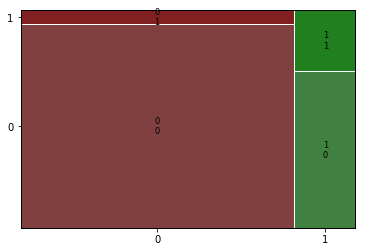

In [39]:
mosaic(ndf,['not_insured','FPOBP'])
plt.show()